In [ ]:
from datasets import load_dataset
ds = load_dataset("ccdv/arxiv-classification", "default")

In [ ]:
test_text = ds['test']['text']
test_label = ds['test']['label']
print(test_text[0][:200], test_label[0])

In [4]:
import torch
from model import GPT
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Device: {device}')

checkpoint_path = 'logging/last.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = GPT(checkpoint['config'])
state_dict = {k.replace("_orig_mod.", ""): v for k, v in checkpoint['model'].items()}
model.load_state_dict(state_dict)
model.to(device)
model.eval()

Device: cpu


GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50304, 768)
    (wpe): Embedding(1024, 768)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (gelu): GELU(approximate='tanh')
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50304, bias=False)
)

In [42]:
outputs = {}
def get_logits_and_ln_f_output(input_data):
    def hook_fn(module, input, output):
        outputs[module.__class__.__name__] = output
    
    # Register hooks for the two specific layers
    hook_handle1 = model.transformer['ln_f'].register_forward_hook(hook_fn)
    hook_handle2 = model.transformer['wte'].register_forward_hook(hook_fn)

    with torch.no_grad():
        logits, loss = model(input_data)

    wte_output = outputs['Embedding']
    ln_f_output = outputs['LayerNorm']
    hook_handle1.remove()
    hook_handle2.remove()
    return logits, wte_output, ln_f_output

import tiktoken
enc = tiktoken.get_encoding('gpt2')
x = torch.tensor(enc.encode(test_text[0]))
x = x[:1024].unsqueeze(0)
logits, wte_output, ln_f_output = get_logits_and_ln_f_output(x)

print("input (x): ", x.shape)
print("Logits:", logits.shape)
print("wte output:", wte_output.shape)
print("ln_f output:", ln_f_output.shape)

input (x):  torch.Size([1, 1024])
Logits: torch.Size([1, 1024, 50304])
wte output: torch.Size([1, 1024, 768])
ln_f output: torch.Size([1, 1024, 768])


In [47]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

ln_f_outputs = []
wte_outputs = []
labels = []
for i, text in enumerate(tqdm(test_text[:5], desc="Processing text")):
    x = torch.tensor(enc.encode(text))
    for j in range(0, len(x)-1024, 1024):
        input_ids = x[j:1024+j].unsqueeze(0)
        assert input_ids.shape[1] == 1024
        labels.append(test_label[i])
        logits, wte_output, ln_f_output = get_logits_and_ln_f_output(input_ids)
        ln_f_outputs.append(ln_f_output.view(ln_f_output.size(0), -1).numpy())
        wte_outputs.append(wte_output.view(wte_output.size(0), -1).numpy())
ln_f_outputs_concat = np.concatenate([out for out in ln_f_outputs], axis=0)
wte_outputs_concat = np.concatenate([out for out in wte_outputs], axis=0)
ln_f_outputs_concat.shape, wte_outputs_concat.shape

Processing text:   0%|          | 0/5 [00:00<?, ?it/s]

((79, 786432), (79, 786432))

In [44]:
# ln_f_outputs_concat = np.concatenate([out for out in ln_f_outputs], axis=0)
# wte_outputs_concat = np.concatenate([out for out in wte_outputs], axis=0)
# ln_f_outputs_concat.shape, wte_outputs_concat.shape

((19, 786432), (19, 786432))

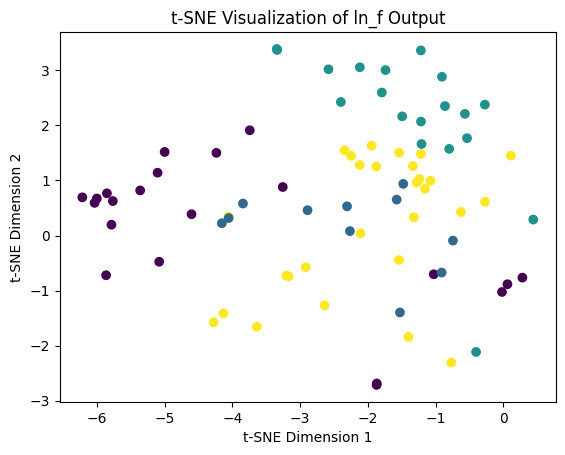

In [48]:
# TSNE ---
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(ln_f_outputs_concat)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
plt.title('t-SNE Visualization of ln_f Output')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

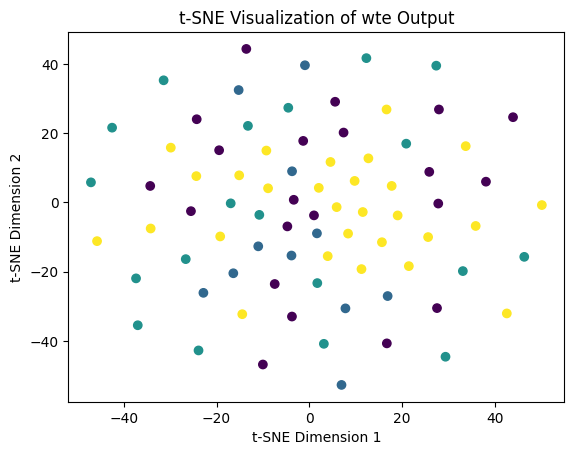

In [49]:
# TSNE ---
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(wte_outputs_concat)
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels)
plt.title('t-SNE Visualization of wte Output')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()